In [119]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.read_csv("1672627CompanyEmployeeData.csv")

In [120]:
"""Since VIF is checked multiple times, I might as well make a function for it"""
def VIF_check(x):
    VIF_data = pd.DataFrame()
    VIF_data['Var'] = x.columns
    VIF_data['VIF'] = [vif(x, i)
                    for i in range(len(x.columns))]
    print(VIF_data)
    return VIF_data

## 1

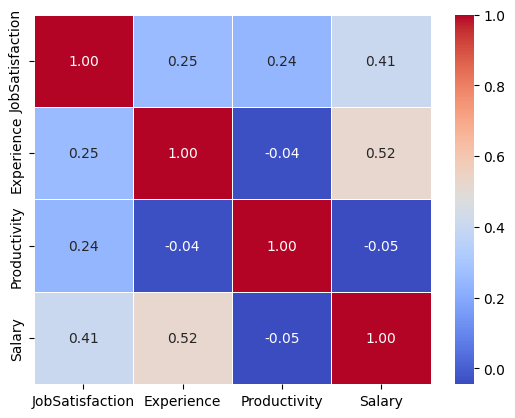

<Figure size 640x480 with 0 Axes>

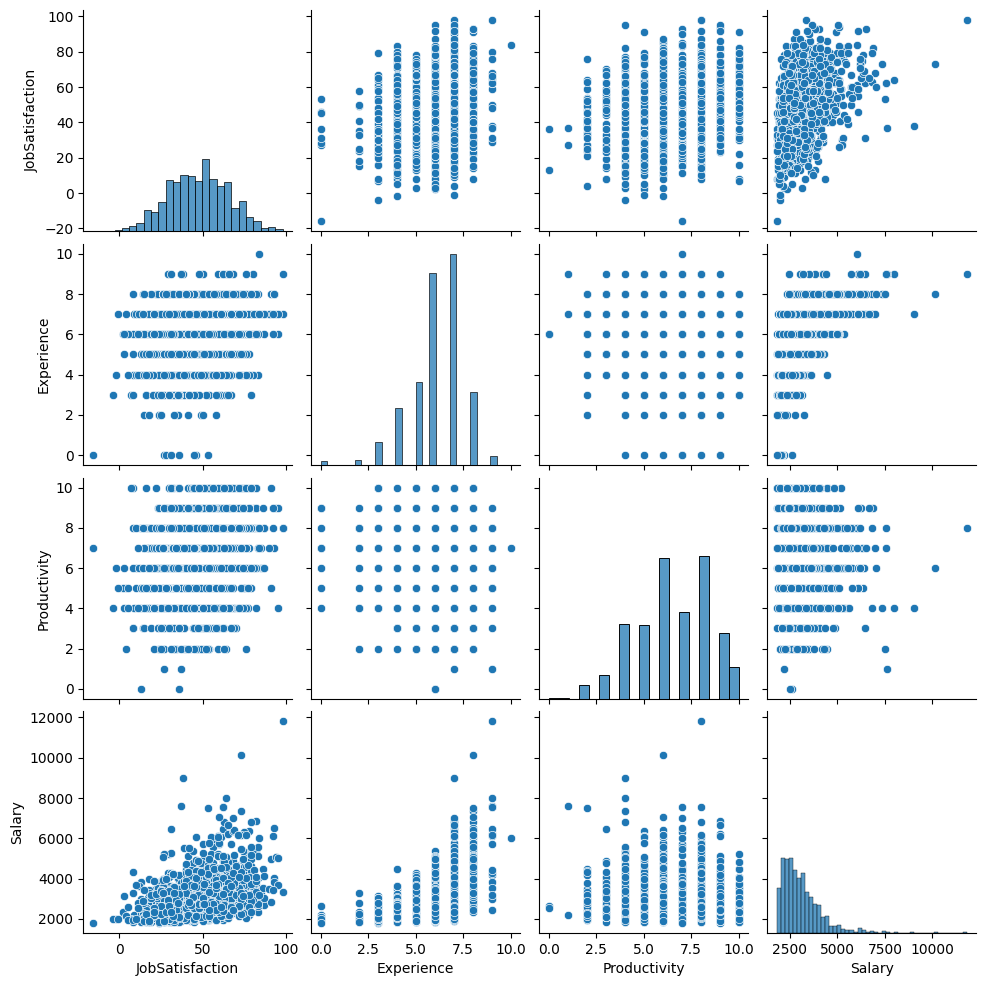

In [121]:
subset = df[['JobSatisfaction', 'Experience', 'Productivity', 'Salary']]
submatrix = subset.corr()

# 1.1 Heatmap
plt.figure()
sn.heatmap(submatrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

#1.2 Scatterplot
plt.figure()
sn.pairplot(subset)
plt.show()

## 2

In [122]:
# Added to stop needing to rerun from start as get_dummies overwrites df
df = pd.read_csv("1672627CompanyEmployeeData.csv")
df = pd.get_dummies(df, columns=['Department', 'Education', 'HealthWellness'], drop_first=True).astype(int)

# 2.1 dummies and regression model
x = df.drop('JobSatisfaction', axis=1)
x = sm.add_constant(x)
y = df['JobSatisfaction']

model = sm.OLS(y, x).fit()
print(model.summary())

# 2.2 VIF check
VIF_check(x)

"""p1: ManagementSatisfaction and PerformanceRating have a VIF of about 25.039881 (makes sense)
ManagementSatisfaction has a greater coeficient and a lower p-value. 
Besides, a score from the employee itself probably better reflects job satisfaction."""

x = x.drop(['PerformanceRating'], axis=1)

model = sm.OLS(y, x).fit()
print(model.summary())

# Second VIF check, just to be sure.
VIF_check(x)

# 2.3 APA formatting
from stargazer.stargazer import Stargazer as sg
from IPython.core.display import HTML

table = sg([model])
HTML(table.render_html())

                            OLS Regression Results                            
Dep. Variable:        JobSatisfaction   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     62.01
Date:                Sun, 13 Oct 2024   Prob (F-statistic):          2.25e-141
Time:                        22:55:12   Log-Likelihood:                -5447.5
No. Observations:                1350   AIC:                         1.093e+04
Df Residuals:                    1334   BIC:                         1.101e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -3

## 3

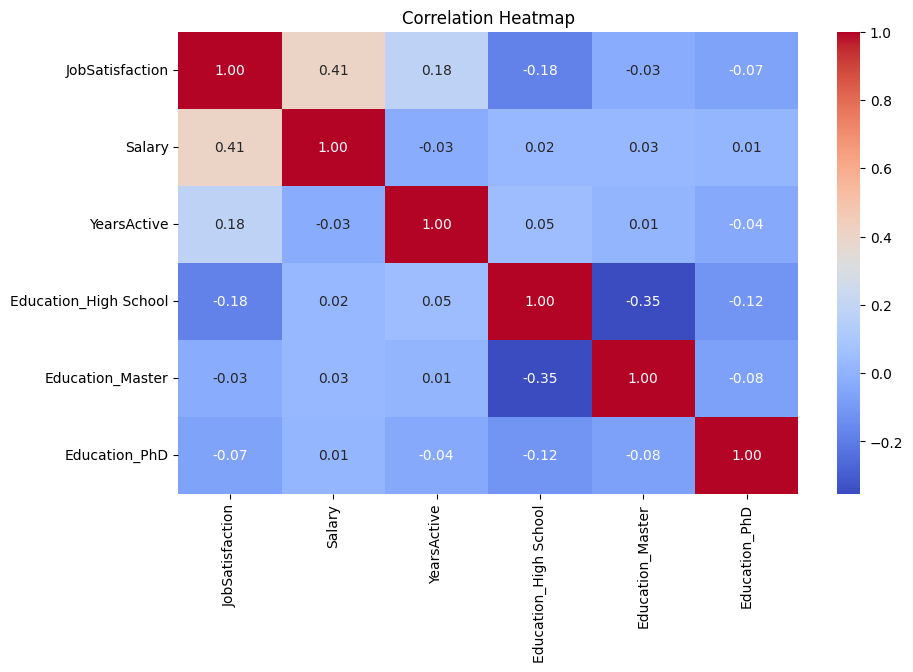

                     Var       VIF
0                  const  6.346870
1                 Salary  1.003544
2            YearsActive  1.005058
3  Education_High School  1.176045
4       Education_Master  1.164007
5          Education_PhD  1.032864
                            OLS Regression Results                            
Dep. Variable:        JobSatisfaction   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     97.85
Date:                Sun, 13 Oct 2024   Prob (F-statistic):           4.55e-88
Time:                        22:55:12   Log-Likelihood:                -5595.1
No. Observations:                1350   AIC:                         1.120e+04
Df Residuals:                    1344   BIC:                         1.123e+04
Df Model:                           5                                         
Covariance Type:            nonrobust       

In [123]:
from sklearn.preprocessing import MinMaxScaler

x = df[['JobSatisfaction', 'Salary', 'YearsActive', 'Education_High School', 'Education_Master', 'Education_PhD']]
correlations = x.corr()

plt.figure(figsize=(10, 6))
sn.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Normalizing Salary and years active as the coeficient would otherwise be comparing euros with years.
# Education dummies aren't normalized as it makes no sense to normalize binary 0/1 values.

scaler = MinMaxScaler()
x = x.drop('JobSatisfaction', axis=1)
x[['Salary', 'YearsActive']] = scaler.fit_transform(x[['Salary', 'YearsActive']])
x = sm.add_constant(x)

y = df['JobSatisfaction']

# VIF check just to be sure
VIF_check(x)

model = sm.OLS(y, x).fit()
print(model.summary())

## 4

In [124]:
from sklearn.model_selection import RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler

scoring = 'neg_mean_absolute_error'
# 4.1 linear regression
df = pd.read_csv('1672627car_data.csv')

# Only seats contains null, but this works and ensures no other column contains na either
df = df.dropna()

df = pd.get_dummies(df, columns=['fuel', 'seller_type', 'transmission', 'owner'], drop_first=True).astype(int)
x = df.drop('selling_price', axis=1)
y = df['selling_price']
print(df.head())


cv = RepeatedKFold(n_splits=5,
                   random_state=42)
lr = LinearRegression()
lrscores = cross_val_score(lr, x, y, scoring='neg_mean_absolute_error', cv=cv)
lrMAE = np.mean(np.absolute(lrscores))
print(f"prediction error LR: {lrMAE}")

# 4.2.0 LR with Ridge/Lasso
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
x = pd.DataFrame(x)

ridge = Ridge(alpha=1)
scoresridge = cross_val_score(ridge, x, y, scoring=scoring, cv=cv)
RidMAE = np.mean(np.absolute(scoresridge))
print(f"prediction error Ridge: {RidMAE}")

lasso = Lasso(alpha=1)
scoreslasso = cross_val_score(lasso, x, y, scoring=scoring, cv=cv)
LasMAE = np.mean(np.absolute(scoreslasso))
print(f"prediction error Lasso: {LasMAE}")

# 4.2.5 Adding gridsearch for alpha values
alpha_range = np.arange(start=1, stop=900, step=1)
param = {'alpha':alpha_range}
lasso = Lasso()
ridge = Ridge()

LassoM = GridSearchCV(lasso, param_grid=param, scoring=scoring, cv=5)
LassoM.fit(x, y)
best_alpha = LassoM.best_params_['alpha']
best_score = -LassoM.best_score_ 
print(f"Best Lasso alpha: {best_alpha}")
print(f"Best Lasso MAE: {best_score}")

ridgem = GridSearchCV(ridge, param_grid=param, scoring=scoring, cv=5)
ridgem.fit(x, y)
best_alpha = ridgem.best_params_['alpha']
best_score = -ridgem.best_score_ 
print(f"Best Ridge alpha: {best_alpha}")
print(f"Best Ridge MAE: {best_score}")


   year  selling_price  km_driven  mileage  engine  max_power  seats  \
0  2012         229999      50000       20     998         67      5   
1  2019         650000       5621       22    1197         81      5   
2  2018        1590000      25000       14    1798        138      5   
3  2013         225000      58343       21     998         67      5   
4  2015         229999      34000       21     814         55      5   

   fuel_Diesel  fuel_LPG  fuel_Petrol  seller_type_Individual  \
0            0         0            1                       1   
1            0         0            1                       0   
2            0         0            1                       0   
3            0         0            1                       0   
4            0         0            1                       1   

   seller_type_Trustmark Dealer  transmission_Manual  \
0                             0                    1   
1                             1                    0   
2       

##### 4.3

In [ ]:
import tensorflow as tf 
from scikeras.wrappers import KerasRegressor

def create_baseline():
    # create model
    nnmodel = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(x.shape[1],)),
        tf.keras.layers.Dense(512, activation='elu'), #hidden layer
        tf.keras.layers.Dense(512, activation='elu'), #hidden layer
        tf.keras.layers.Dense(512, activation='elu'), #hidden layer
        tf.keras.layers.Dense(512, activation='elu'), #hidden layer
        tf.keras.layers.Dense(1)  # Output layer
    ])
    # Compile model
    nnmodel.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae']) #compile the model based 
    return nnmodel
# evaluate model  (note if you get an error, upgrade the packages! module not found keras.api_v2 error was because of tensorflow!)
estimator = KerasRegressor(build_fn=create_baseline, epochs=100, batch_size=32,verbose=0) #you have to use the kerasRegressor wrapper for nn models
kfold = RepeatedKFold(n_splits=5, n_repeats = 1) #I'm using just 5 splits and 1 repeat to save time, but more splits and repeats will be more accurate
results = cross_val_score(estimator, X, y, cv=kfold,scoring='neg_mean_absolute_error') #create the results of the cross validation
print('the average prediction error is: %.0f' % np.mean(np.absolute(results))) #print the average error